In [1]:
import numpy as np
import scipy.ndimage
plt.style.use("default")
import time

## Generating a latent space representation
To make it more "understandable" where material is placed we generate a slowly varying landscape by interpolation of a low resolution map.

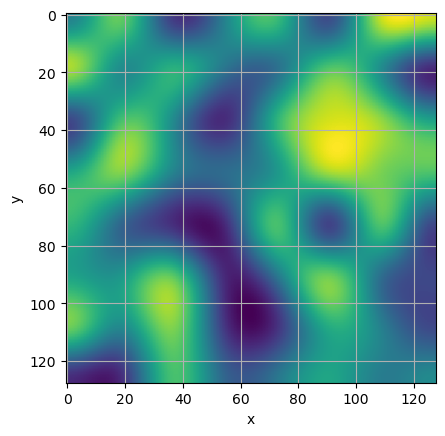

In [2]:
features = 8
zoom = 16
heatmap = np.random.random((features,features))-0.5
large_heatmap = scipy.ndimage.zoom(heatmap, zoom)
plt.imshow(large_heatmap)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

N=features*zoom

## Generating the brush

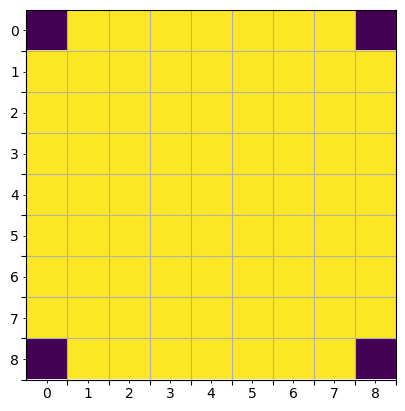

In [19]:
kernel_size=9
brush = np.ones((kernel_size, kernel_size))
brush[0,0] = 0
brush[0,-1] = 0
brush[-1,0] = 0
brush[-1,-1] = 0
brush = brush.astype(bool)

nx, ny = brush.shape

plt.imshow(brush)
ax = plt.gca()
ax.set_yticks(np.arange(nx)+0.5)
ax.set_yticklabels(["" for i in range(nx)])
ax.set_xticks(np.arange(ny)+0.5)
ax.set_xticklabels(["" for i in range(ny)])
ax.set_yticks(np.arange(nx), minor=True)
ax.set_yticklabels([f"{i}" for i in range(nx)], minor=True)
ax.set_xticks(np.arange(ny), minor=True)
ax.set_xticklabels([f"{i}" for i in range(ny)], minor=True)
plt.grid()

## Running the Generator

In [45]:
def dilate(img, brush):
    global time_dilate
    time_dilate -= time.process_time() 
    dil = scipy.ndimage.morphology.binary_dilation(img, brush)
    time_dilate += time.process_time() 
    return dil

def existing_pixels(touches, brush):
    return dilate(touches, brush)

def impossible_touches(existing_other, brush):
    return dilate(existing_other, brush)

def valid_touches(impossible, touches):
    return np.logical_and(np.logical_not(impossible), np.logical_not(touches))

def possible_pixels(valid, touches, brush):
    possible_touches = np.logical_or(touches, valid)
    return dilate(possible_touches, brush)

def required_pixels(existing, possible_other):
    return np.logical_and(np.logical_not(existing), np.logical_not(possible_other))

def resolving_touches(required, valid, brush):
    return np.logical_and(dilate(required, brush), valid)

def free_touches(possible_other, existing_other, valid, brush):
    dilated = dilate(np.logical_or(possible_other, existing_other), brush)
    return np.logical_and(np.logical_not(dilated), valid)


def select_single(s_valid, v_valid, s_suggest, v_suggest, brush, t_s, t_v, p_s_existing, p_v_existing, track_existing=False):
    s_weights = scipy.ndimage.convolve(s_suggest, brush) # TODO eliminate this convolution!
    v_weights = -scipy.ndimage.convolve(v_suggest, brush)

    s_weights[np.logical_not(s_valid)] = np.nan
    v_weights[np.logical_not(v_valid)] = np.nan

    max_s = max_v = -np.inf
    if s_valid.any():
        max_pos_s = np.nanargmax(s_weights)
        max_s = s_weights.flat[max_pos_s]
    
    if v_valid.any():
        max_pos_v = np.nanargmax(v_weights)
        max_v = v_weights.flat[max_pos_v]

    if  max_s > max_v:
      t_s.flat[max_pos_s] = True
      track(p_s_existing, max_pos_s, track_existing)
    else:
      t_v.flat[max_pos_v] = True
      track(p_v_existing, max_pos_v, track_existing)



def track(existing, pos, act = False):
  if not act:
    return existing
  l = len(brush)//2
  idx = np.unravel_index(pos, existing.shape)

  # slightly complicated :/
  dw = [min(l, idx_i) for idx_i in idx] #from the brushcenter how many pixels "down" the axis
  up = [min(l+1, max(l_existing - idx_i, 0)) for (idx_i, l_existing) in zip(idx, existing.shape)]
  existing[
    idx[0]-dw[0]:idx[0]+up[0], 
    idx[1]-dw[1]:idx[1]+up[1]] |= brush[
        l -dw[0]:l     +up[0],
        l -dw[1]:l     +up[1],
    ]

debug = True
def log(*args):
  if debug:
    print(*args)

opt_track_existing = True

def generate():
  time_update = 0
  time_select = 0 
  global time_dilate
  time_dilate = 0
  time_existing = 0
  time_impossible = 0
  time_valid = 0
  time_possible = 0
  time_required = 0
  time_resolving = 0
  time_free = 0

  s_suggest = large_heatmap.copy()
  v_suggest = large_heatmap.copy()


  t_s = np.zeros_like(s_suggest).astype(bool)
  t_v = t_s.copy()
  p_s_existing = t_s.copy()
  p_v_existing = t_s.copy()

  for i in range(N**2):
      time_update -= time.process_time() 

      if not opt_track_existing:
        time_existing -= time.process_time() 
        p_s_existing = existing_pixels(t_s, brush)
        p_v_existing = existing_pixels(t_v, brush)
        time_existing += time.process_time() 

      s_suggest[p_s_existing] = 0
      v_suggest[p_v_existing] = 0

      time_impossible -= time.process_time() 
      t_s_impossible = impossible_touches(p_v_existing, brush)
      t_v_impossible = impossible_touches(p_s_existing, brush)
      time_impossible += time.process_time() 

      time_valid -= time.process_time() 
      t_s_valid = valid_touches(t_s_impossible, t_s)
      t_v_valid = valid_touches(t_v_impossible, t_v)
      time_valid += time.process_time() 

      time_possible -= time.process_time() 
      p_s_possible = possible_pixels(t_s_valid,t_s,brush)
      p_v_possible = possible_pixels(t_v_valid,t_v,brush)
      time_possible += time.process_time() 

      time_required -= time.process_time() 
      p_s_required = required_pixels(p_s_existing, p_v_possible)
      p_v_required = required_pixels(p_v_existing, p_s_possible)
      time_required += time.process_time() 

      time_resolving -= time.process_time() 
      t_s_resolving = resolving_touches(p_s_required, t_s_valid, brush)
      t_v_resolving = resolving_touches(p_v_required, t_v_valid, brush)
      time_resolving += time.process_time() 

      time_free -= time.process_time() 
      t_s_free = free_touches(p_v_possible, p_v_existing, t_s_valid, brush)
      t_v_free = free_touches(p_s_possible, p_s_existing, t_v_valid, brush)
      time_free += time.process_time() 

      time_update += time.process_time() 
      time_select -= time.process_time() 

      if t_s_free.any() or t_v_free.any():
          log(f"{i}: free")
          t_s = np.logical_or(t_s, t_s_free)
          t_v = np.logical_or(t_v, t_v_free)

          if opt_track_existing: # TODO make this more beautifull! Need to keep track of all free
            time_existing -= time.process_time() 
            p_s_existing = existing_pixels(t_s, brush)
            p_v_existing = existing_pixels(t_v, brush)
            time_existing += time.process_time() 

      elif t_s_resolving.any() or t_v_resolving.any():
          log(f"{i}: resolving")
          #p_s_existing, p_v_existing, t_s, t_v = 
          select_single(
            t_s_resolving, t_v_resolving, s_suggest, v_suggest, brush, t_s, t_v, 
            p_s_existing, p_v_existing, track_existing = opt_track_existing)
      elif t_s_valid.any() or t_v_valid.any():
          log(f"{i}: valid")
          #p_s_existing, p_v_existing, t_s, t_v = 
          select_single(
            t_s_valid, t_v_valid, s_suggest, v_suggest, brush, t_s, t_v, 
            p_s_existing, p_v_existing, track_existing = opt_track_existing)
      else:
          print("finished")
          time_select += time.process_time() 
          break

      time_select += time.process_time() 

  plt.figure(figsize = (6,9))
  plt.subplot(221)
  plt.title("Solid and Void")
  plt.imshow(p_s_existing)
  plt.subplot(222)
  plt.title("Solid and Void Touches")
  plt.imshow(t_s.astype(int)-t_v)
  plt.subplot(223)
  plt.imshow(large_heatmap)

  return dict(
    update = time_update,
    select = time_select,
    dilate = time_dilate,
    existing = time_existing,
    impossible = time_impossible,
    valid = time_valid,
    possible = time_possible,
    required = time_required,
    resolving = time_resolving,
    free = time_free
  )

/var/folders/s4/d8sxz9nj0j57pj58g4dc54300000gn/T/ipykernel_83959/1571772634.py:4: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  dil = scipy.ndimage.morphology.binary_dilation(img, brush)


0: valid
1: valid
2: valid
3: valid
4: resolving
5: free
6: valid
7: valid
8: valid
9: free
10: valid
11: resolving
12: free
13: resolving
14: free
15: valid
16: free
17: valid
18: resolving
19: free
20: valid
21: free
22: valid
23: free
24: valid
25: valid
26: free
27: valid
28: free
29: valid
30: free
31: valid
32: valid
33: free
34: valid
35: valid
36: free
37: valid
38: free
39: valid
40: free
41: valid
42: free
43: valid
44: valid
45: free
46: valid
47: valid
48: valid
49: valid
50: valid
51: free
52: valid
53: free
54: valid
55: resolving
56: free
57: valid
58: free
59: valid
60: free
61: valid
62: free
63: valid
64: free
65: valid
66: resolving
67: free
68: valid
69: free
70: valid
71: free
72: valid
73: free
74: valid
75: valid
76: free
77: valid
78: free
79: valid
80: free
81: valid
82: free
83: valid
84: free
85: valid
86: valid
87: resolving
88: free
89: valid
90: free
91: valid
92: free
93: valid
94: free
95: valid
96: valid
97: valid
98: free
99: valid
100: free
101: valid

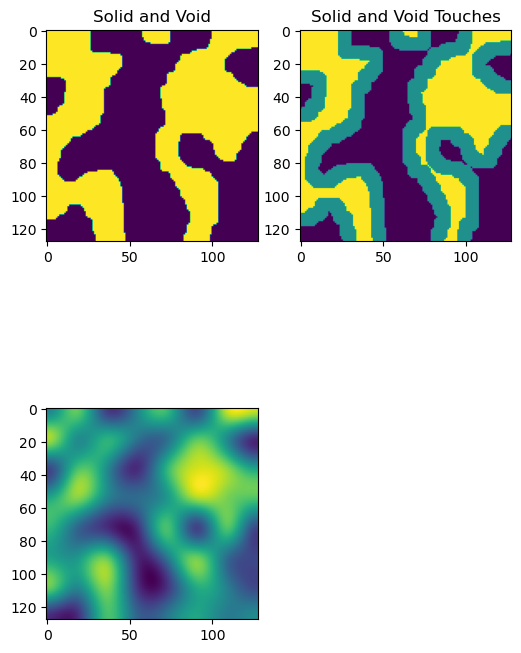

In [48]:
times = generate()

In [49]:
times["update"]+times["select"]

6.070990999999694

No tracking: 6.94s

With tracking: 6.09s